CoT Transfer Effect Analysis
Folder: ../outputs
Excluding: medcalc-llama, meta-llama, deepseek, grpo
--------------------------------------------------------------------------------

Found 10 CoT settings WITH answer


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


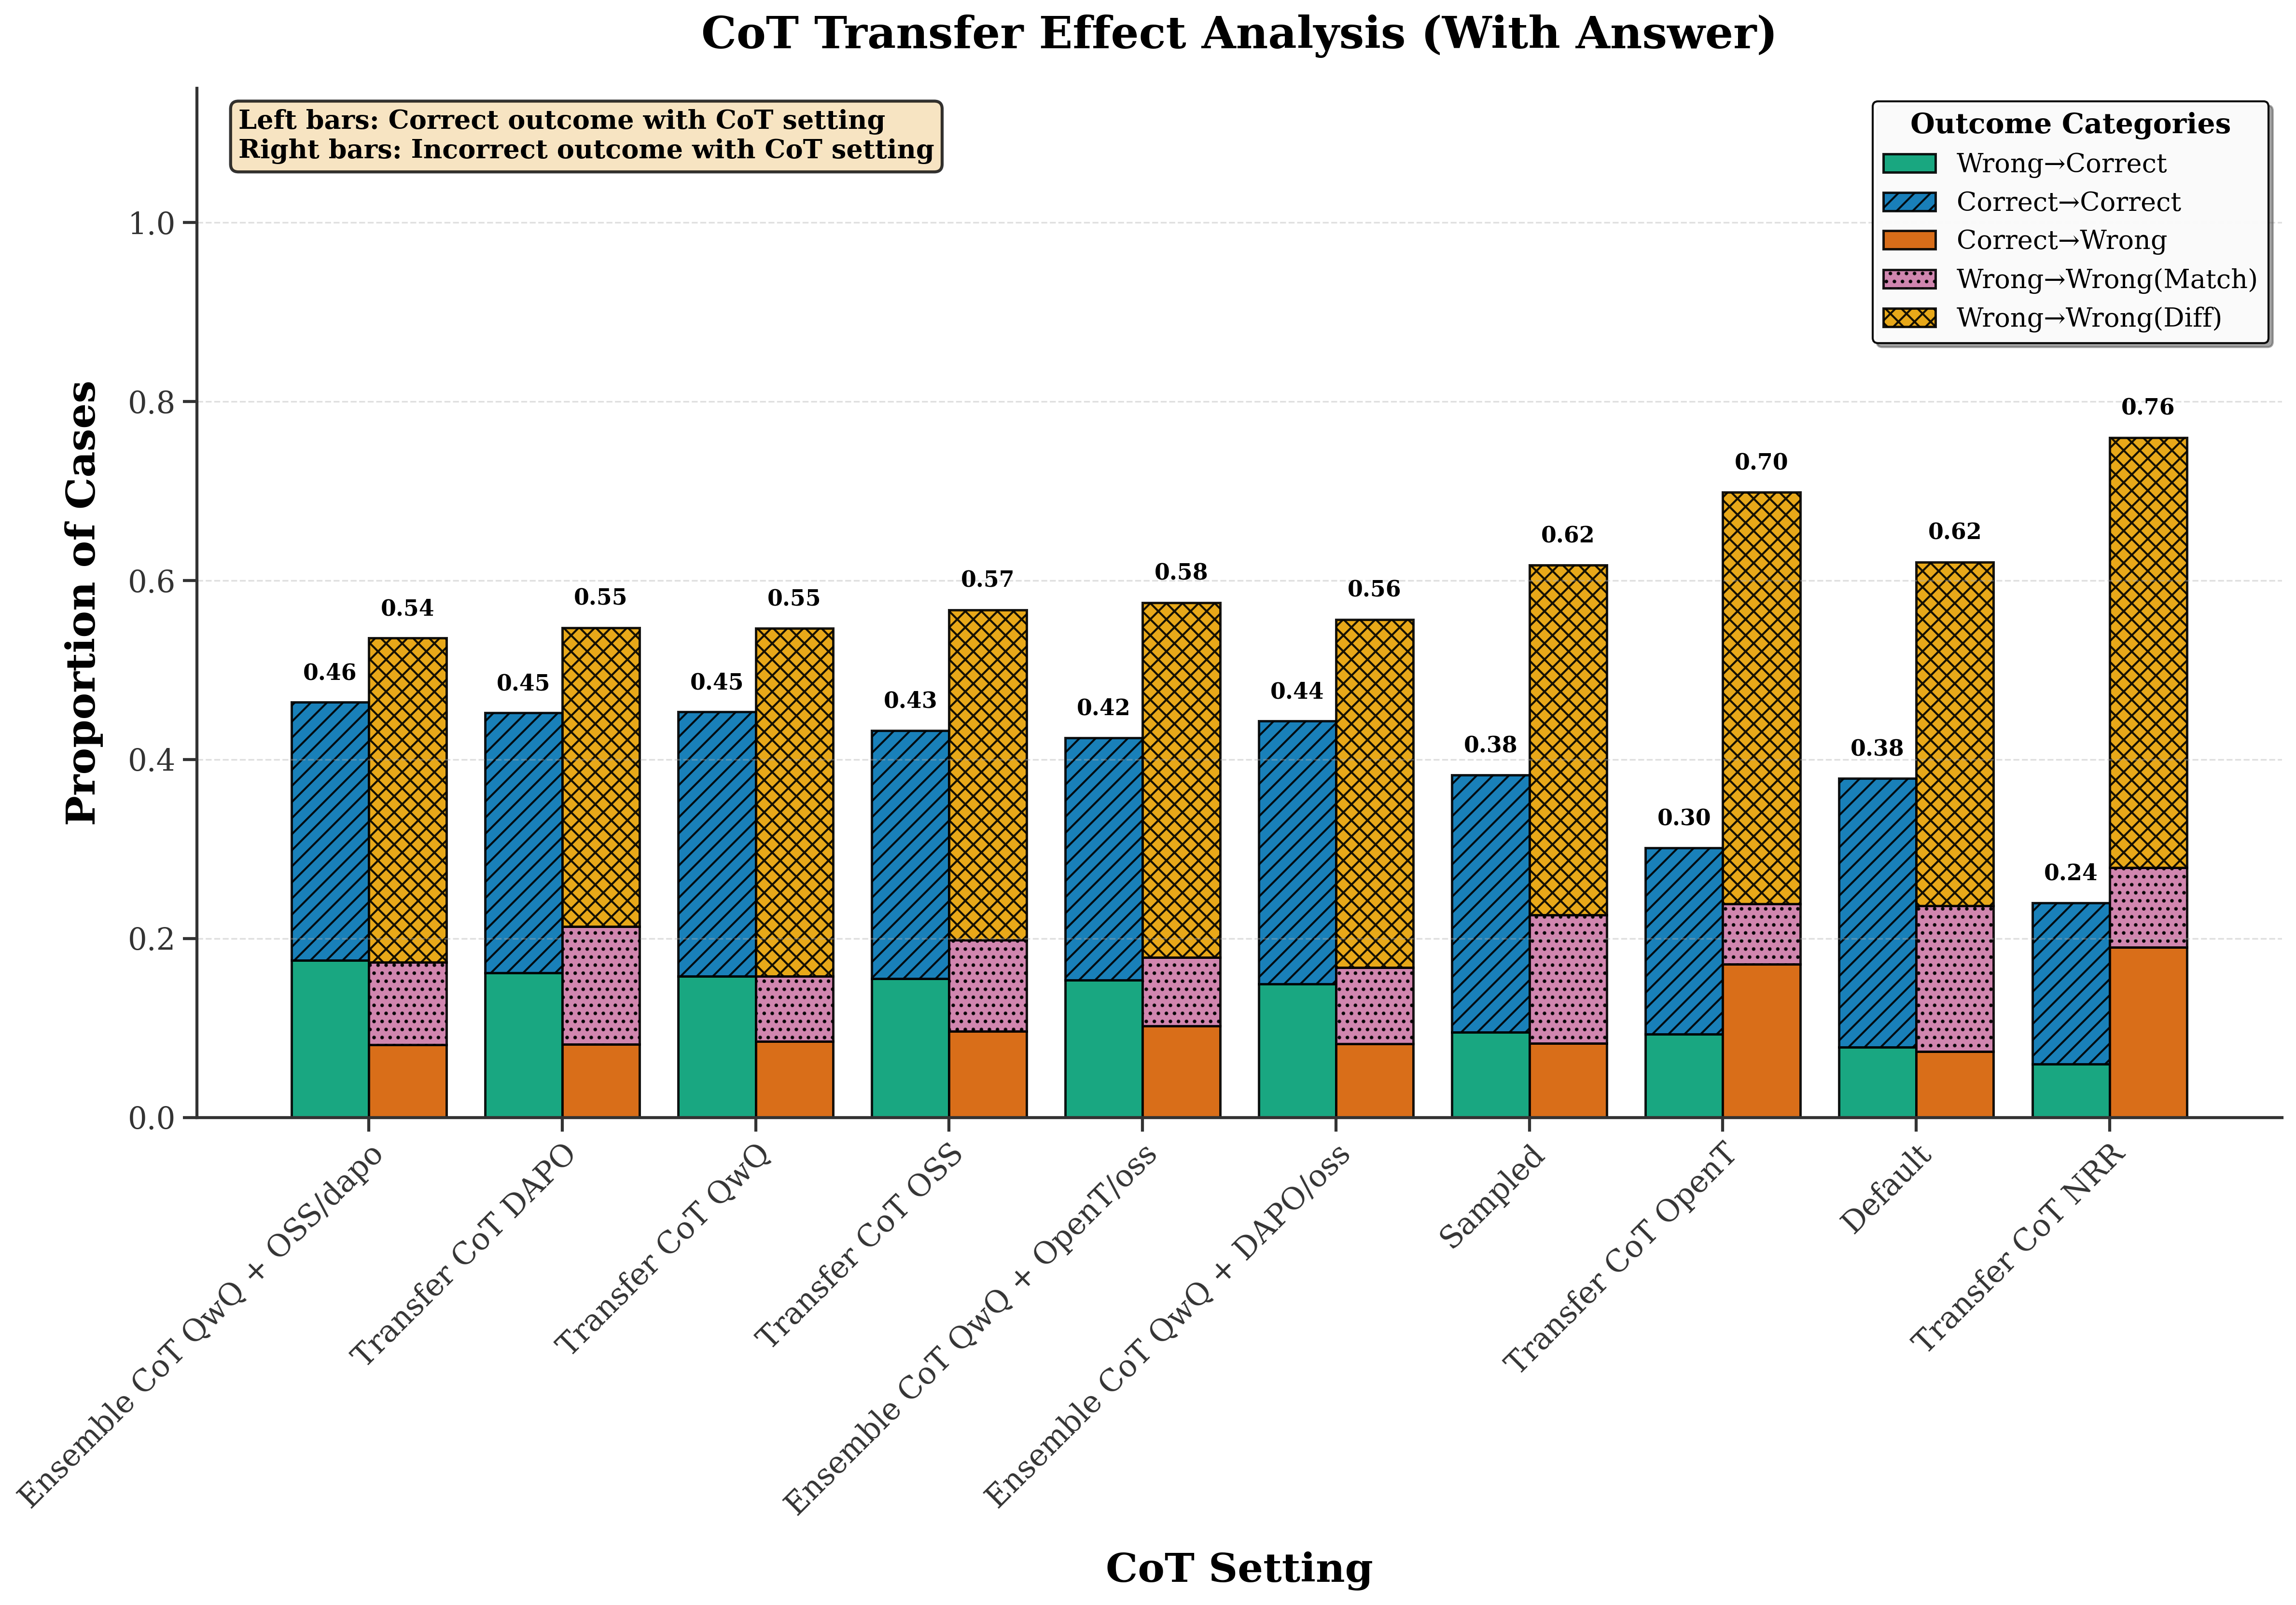


CoT TRANSFER EFFECT ANALYSIS (WITH ANSWER)

Wrong→Correct:
--------------------------------------------------------------------------------
 1. Ensemble CoT QwQ + OSS/dapo        : 17.6% (  69/ 392 cases, 5 models)
 2. Transfer CoT DAPO                  : 16.2% (  63/ 389 cases, 5 models)
 3. Transfer CoT QwQ                   : 15.8% (  61/ 386 cases, 5 models)
 4. Transfer CoT OSS                   : 15.5% (  61/ 393 cases, 5 models)
 5. Ensemble CoT QwQ + OpenT/oss       : 15.3% (  60/ 391 cases, 5 models)
 6. Ensemble CoT QwQ + DAPO/oss        : 14.9% (  58/ 388 cases, 5 models)
 7. Sampled                            :  9.6% (  38/ 397 cases, 5 models)
 8. Transfer CoT OpenT                 :  9.4% (  36/ 385 cases, 5 models)
 9. Default                            :  7.9% (  31/ 393 cases, 5 models)
10. Transfer CoT NRR                   :  6.0% (  23/ 383 cases, 5 models)

Correct→Wrong:
--------------------------------------------------------------------------------
 1. Transfer

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


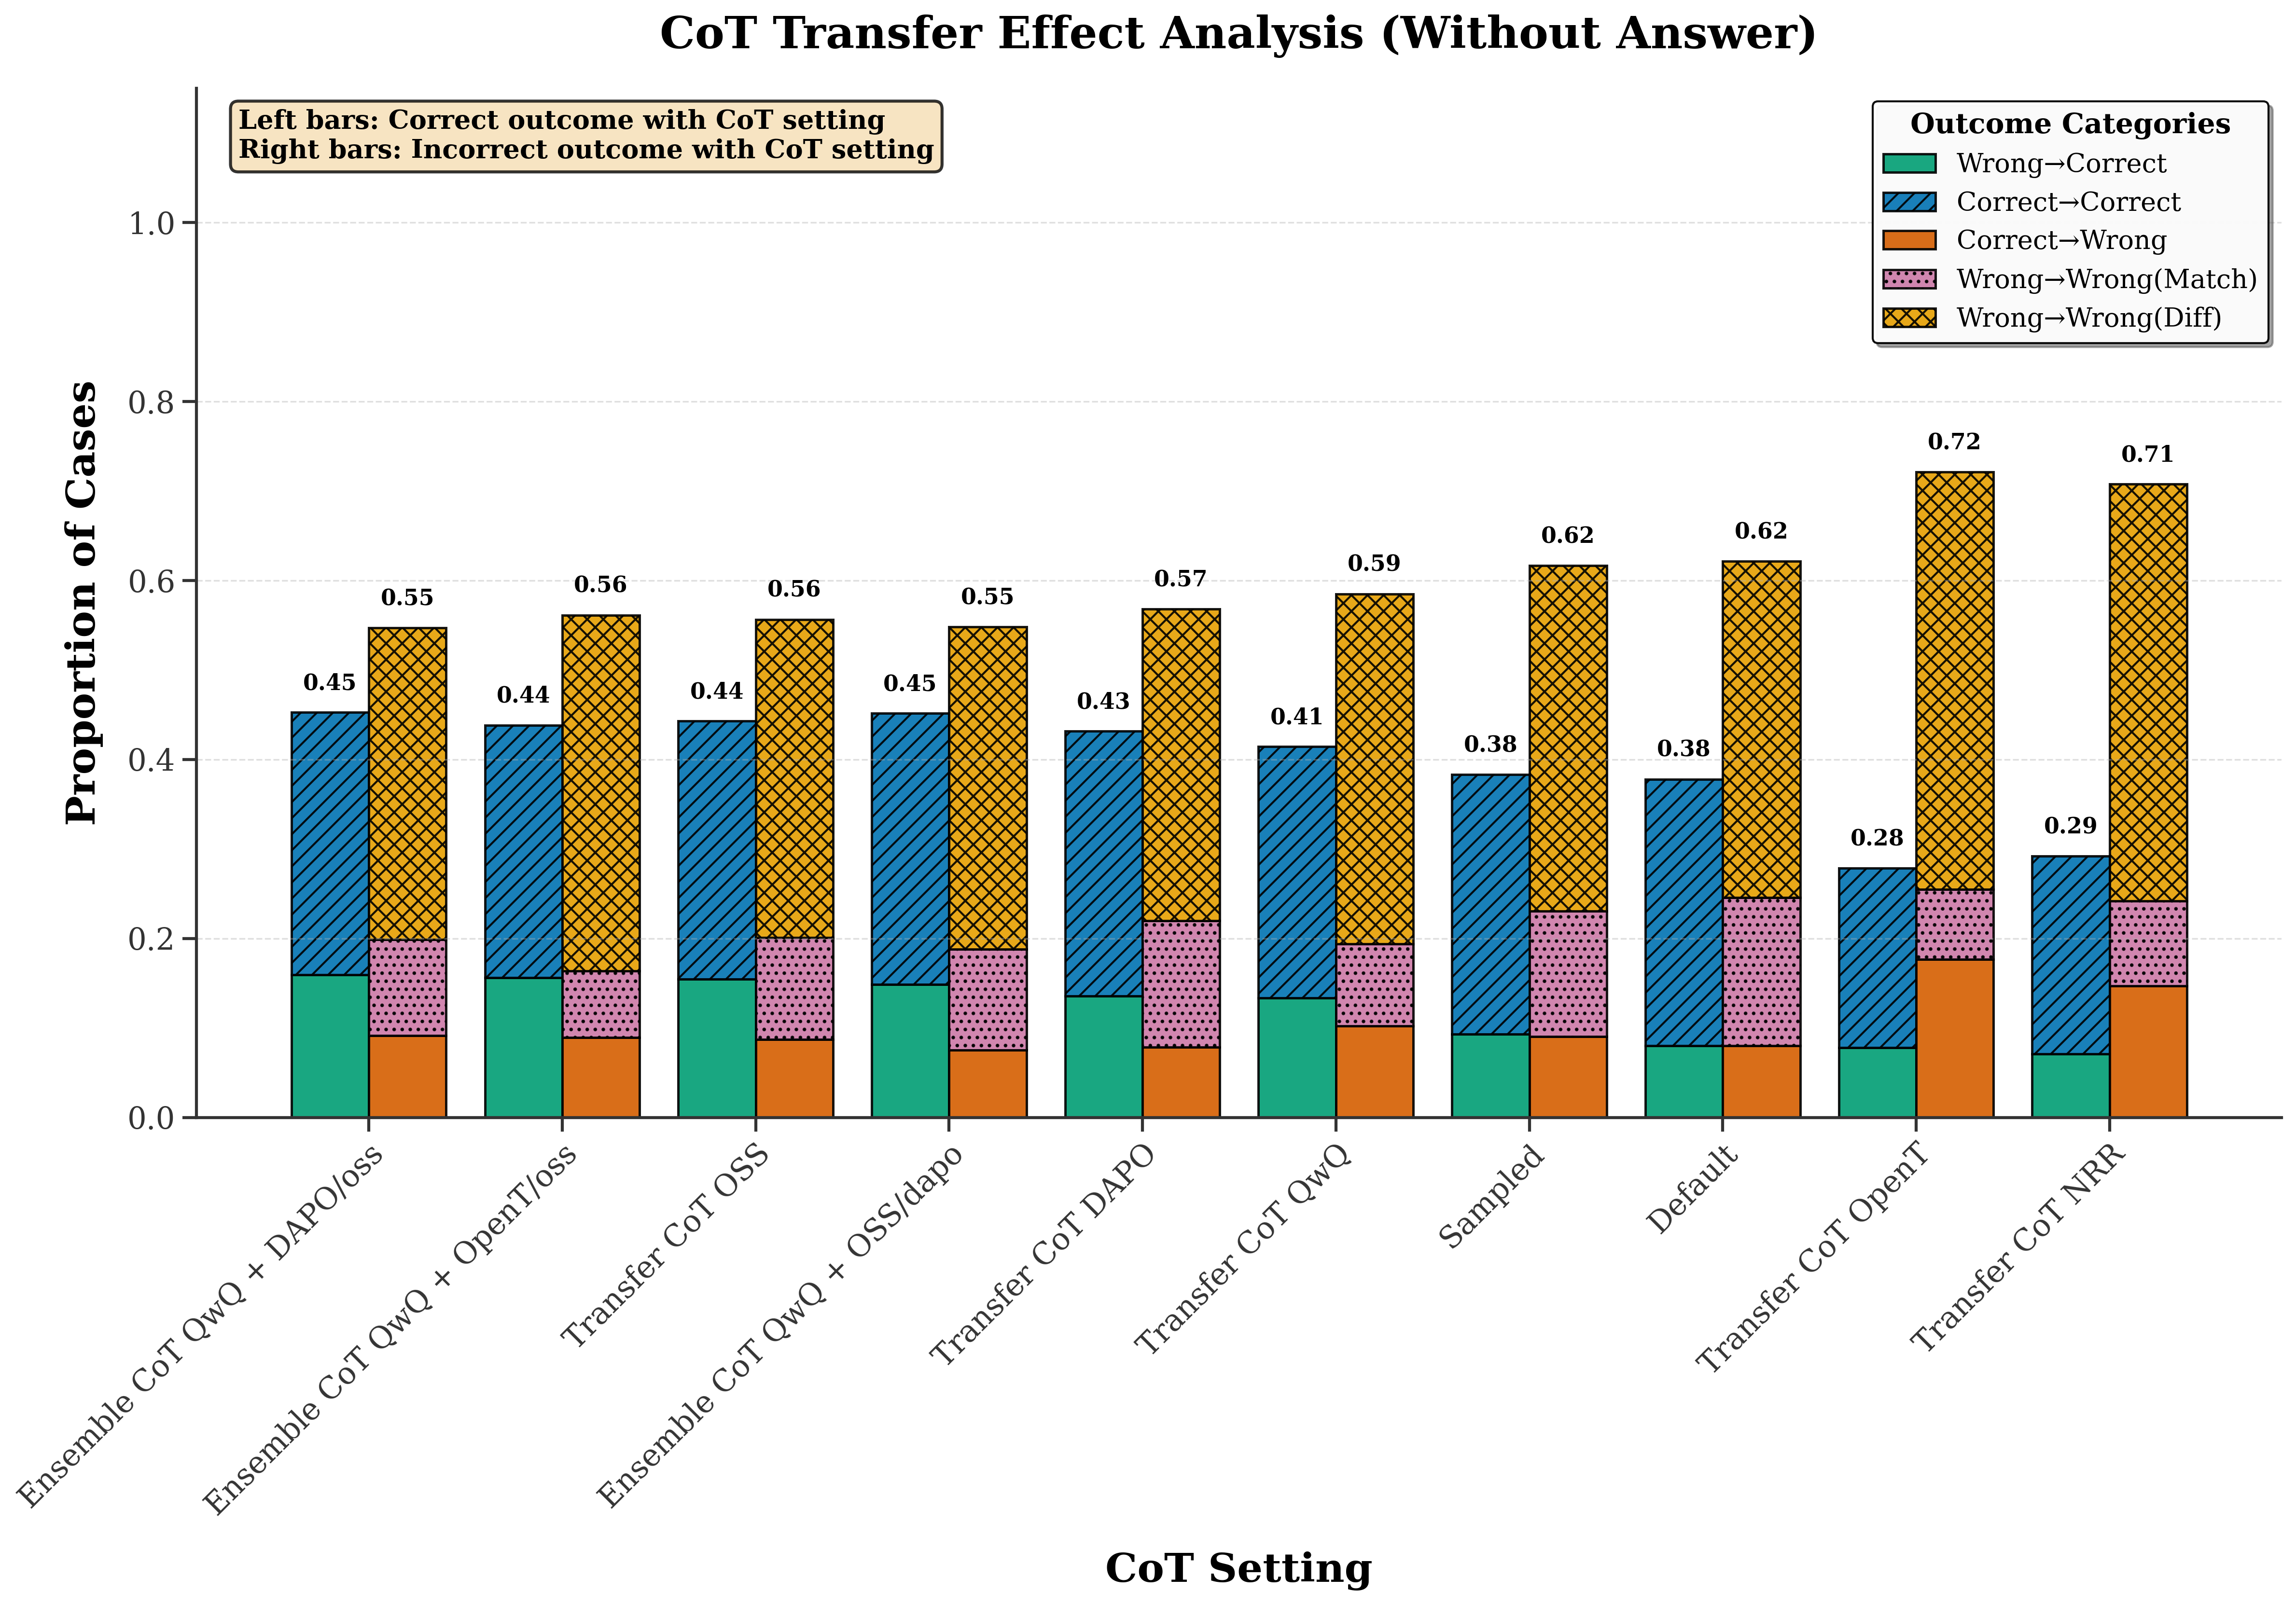


CoT TRANSFER EFFECT ANALYSIS (WITHOUT ANSWER)

Wrong→Correct:
--------------------------------------------------------------------------------
 1. Ensemble CoT QwQ + DAPO/oss        : 16.0% (  61/ 382 cases, 5 models)
 2. Ensemble CoT QwQ + OpenT/oss       : 15.6% (  61/ 390 cases, 5 models)
 3. Transfer CoT OSS                   : 15.5% (  60/ 388 cases, 5 models)
 4. Ensemble CoT QwQ + OSS/dapo        : 14.9% (  57/ 383 cases, 5 models)
 5. Transfer CoT DAPO                  : 13.6% (  52/ 382 cases, 5 models)
 6. Transfer CoT QwQ                   : 13.4% (  51/ 381 cases, 5 models)
 7. Sampled                            :  9.3% (  36/ 386 cases, 5 models)
 8. Default                            :  8.0% (  31/ 386 cases, 5 models)
 9. Transfer CoT OpenT                 :  7.8% (  30/ 384 cases, 5 models)
10. Transfer CoT NRR                   :  7.1% (  27/ 380 cases, 5 models)

Correct→Wrong:
--------------------------------------------------------------------------------
 1. Trans

In [4]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
warnings.filterwarnings('ignore')

plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times', 'DejaVu Serif'],
    'font.size': 16,
    'figure.dpi': 300
})

MODEL_NAMES = {
    'openai_gpt-oss-20b': 'OSS',
    'BytedTsinghua-SIA_DAPO-Qwen-32B': 'DAPO', 
    'Qwen_QwQ-32B': 'QwQ',
    'open-thoughts_OpenThinker-7B': 'OpenT',
    'nvidia_Nemotron-Research-Reasoning-Qwen-1.5B': 'NRR'
}

EXCLUDED_MODELS = ['medcalc-llama', 'meta-llama', 'deepseek', 'grpo']
CONDITIONS = ['Wrong→Correct', 'Correct→Wrong', 'Correct→Correct', 
              'Wrong→Wrong(Match)', 'Wrong→Wrong(Diff)']

# Enhanced color-blind friendly palette with distinct patterns
# Using Paul Tol's color scheme for better distinction
EVENTUALLY_CORRECT_COLORS = {
    'Wrong→Correct': '#009E73',  # Bluish green (improvement)
    'Correct→Correct': '#0072B2'  # Blue (maintained correctness)
}

OTHER_CASES_COLORS = {
    'Correct→Wrong': '#D55E00',  # Vermillion (regression)
    'Wrong→Wrong(Match)': '#CC79A7',  # Reddish purple (consistent error)
    'Wrong→Wrong(Diff)': '#E69F00'  # Orange (variable error)
}

# Hatching patterns for additional distinction
EVENTUALLY_CORRECT_PATTERNS = {
    'Wrong→Correct': '',  # Solid
    'Correct→Correct': '///'  # Diagonal lines
}

OTHER_CASES_PATTERNS = {
    'Correct→Wrong': '',  # Solid
    'Wrong→Wrong(Match)': '...',  # Dots
    'Wrong→Wrong(Diff)': 'xxx'  # Crosses
}

def should_exclude_model(name):
    return any(excl in name.lower() for excl in EXCLUDED_MODELS)

def parse_jsonl(filepath):
    try:
        with open(filepath, 'r') as f:
            return [json.loads(line) for line in f if line.strip()]
    except:
        return []

def is_correct(datapoint, prefix=""):
    result = datapoint.get(f"{prefix}Result", "")
    answer = datapoint.get(f"{prefix}Answer" if prefix else "LLM Answer", "")
    
    invalid = ["not defined", "N/A", "does not match", "are not permitted"]
    return None if any(marker in str(answer) for marker in invalid) else result == "Correct"

def get_cot_setting_name(filename):
    """Extract CoT setting name and whether it has answer. Returns list of settings."""
    has_answer = 'without_answer' not in filename
    
    # Transfer settings (including self-transfer as Default)
    match = re.match(r'(.+)_thoughts_to_(.+)_zero_shot', filename)
    if match:
        source, target = match.group(1), match.group(2)
        source_short = MODEL_NAMES.get(source, source)
        
        # Self-transfer appears in both Default and Transfer CoT X
        if source == target:
            return [('Default', has_answer), (f'Transfer CoT {source_short}', has_answer)]
        else:
            return [(f'Transfer CoT {source_short}', has_answer)]
    
    # Ensemble settings
    if '_gen_' in filename and '_eval_' in filename:
        gen = re.search(r'_gen_(.+)_eval', filename)
        eval_match = re.search(r'_eval_(.+).json', filename)
        if gen and eval_match:
            gen_map = {"qwq_dapo": "QwQ + DAPO", "qwq_opent": "QwQ + OpenT", 
                      "qwq_oss": "QwQ + OSS"}
            gen_short = gen_map.get(gen.group(1), MODEL_NAMES.get(gen.group(1), gen.group(1)))
            eval_short = MODEL_NAMES.get(eval_match.group(1), eval_match.group(1))
            return [(f'Ensemble CoT {gen_short}/{eval_short}', has_answer)]
    
    # Sampled settings
    if '_with_sampling' in filename:
        return [('Sampled', has_answer)]
    
    return []

def get_target_model(filename):
    if '_thoughts_to_' in filename:
        match = re.match(r'.+_thoughts_to_(.+)_zero_shot', filename)
        return match.group(1) if match else None
    
    for model in MODEL_NAMES:
        if model in filename:
            return model
    return None

def find_no_cot_baseline(folder_path, target_model):
    for f in os.listdir(folder_path):
        if f.endswith('_zero_shot_empty.jsonl') and target_model in f:
            return f
    return None

def classify_outcome(no_cot_correct, cot_correct, no_cot_answer, cot_answer):
    if not no_cot_correct and cot_correct:
        return 'Wrong→Correct'
    elif no_cot_correct and not cot_correct:
        return 'Correct→Wrong'
    elif no_cot_correct and cot_correct:
        return 'Correct→Correct'
    else:
        return 'Wrong→Wrong(Match)' if no_cot_answer == cot_answer else 'Wrong→Wrong(Diff)'

def analyze_single_comparison(no_cot_data, cot_data):
    counts = {cond: 0 for cond in CONDITIONS + ['total_valid']}
    
    for no_cot_dp, cot_dp in zip(no_cot_data, cot_data):
        has_target = "Target Result" in cot_dp
        
        no_cot_correct = is_correct(no_cot_dp)
        cot_correct = is_correct(cot_dp, "Target " if has_target else "")
        
        if no_cot_correct is None or cot_correct is None:
            continue
        
        no_cot_answer = no_cot_dp.get("LLM Answer", "")
        cot_answer = cot_dp.get("Target Answer" if has_target else "LLM Answer", "")
        
        counts['total_valid'] += 1
        counts[classify_outcome(no_cot_correct, cot_correct, no_cot_answer, cot_answer)] += 1
    
    return counts if counts['total_valid'] > 0 else None

def aggregate_results(folder_path, setting_pairs):
    results = {}
    
    for setting, pairs in setting_pairs.items():
        all_counts = []
        
        for no_cot_file, cot_file in pairs:
            no_cot_data = parse_jsonl(os.path.join(folder_path, no_cot_file))
            cot_data = parse_jsonl(os.path.join(folder_path, cot_file))
            
            if len(no_cot_data) == len(cot_data):
                counts = analyze_single_comparison(no_cot_data, cot_data)
                if counts:
                    all_counts.append(counts)
        
        if all_counts:
            total_counts = {cond: sum(c[cond] for c in all_counts) for cond in CONDITIONS}
            total_valid = sum(c['total_valid'] for c in all_counts)
            
            results[setting] = {
                'counts': total_counts,
                'total_valid': total_valid,
                'rates': {cond: total_counts[cond] / total_valid for cond in CONDITIONS},
                'num_models': len(all_counts)
            }
    
    return results

def analyze_cot_settings(folder_path):
    if not os.path.exists(folder_path):
        return {}, {}
    
    pairs_with, pairs_without = defaultdict(list), defaultdict(list)
    
    for filename in os.listdir(folder_path):
        if not filename.endswith('.jsonl') or should_exclude_model(filename):
            continue
        
        target_model = get_target_model(filename)
        setting_list = get_cot_setting_name(filename)
        
        if not target_model or not setting_list:
            continue
        
        no_cot_file = find_no_cot_baseline(folder_path, target_model)
        if no_cot_file:
            for cot_setting, has_answer in setting_list:
                target = pairs_with if has_answer else pairs_without
                target[cot_setting].append((no_cot_file, filename))
    
    return aggregate_results(folder_path, pairs_with), aggregate_results(folder_path, pairs_without)

def plot_transfer_analysis(results, suffix=''):
    settings = sorted(results.items(), key=lambda x: x[1]['rates']['Wrong→Correct'], reverse=True)
    
    names = [s[0] for s in settings]
    
    # Group into two stacked bar categories
    eventually_correct_data = {
        'Wrong→Correct': [s[1]['rates']['Wrong→Correct'] for s in settings],
        'Correct→Correct': [s[1]['rates']['Correct→Correct'] for s in settings]
    }
    
    other_cases_data = {
        'Correct→Wrong': [s[1]['rates']['Correct→Wrong'] for s in settings],
        'Wrong→Wrong(Match)': [s[1]['rates']['Wrong→Wrong(Match)'] for s in settings],
        'Wrong→Wrong(Diff)': [s[1]['rates']['Wrong→Wrong(Diff)'] for s in settings]
    }
    
    fig, ax = plt.subplots(figsize=(16, 9))
    x = np.arange(len(names))
    width = 0.4  # Wider bars for better visibility
    
    # Bar 1: Eventually Correct (stacked)
    bottom_correct = np.zeros(len(names))
    for condition in ['Wrong→Correct', 'Correct→Correct']:
        bars = ax.bar(x - width/2, eventually_correct_data[condition], width, 
                     label=condition, 
                     color=EVENTUALLY_CORRECT_COLORS[condition],
                     edgecolor='black', 
                     linewidth=1.2, 
                     bottom=bottom_correct,
                     hatch=EVENTUALLY_CORRECT_PATTERNS[condition],
                     alpha=0.9)
        bottom_correct += eventually_correct_data[condition]
    
    # Bar 2: Other cases (stacked)
    bottom_other = np.zeros(len(names))
    for condition in ['Correct→Wrong', 'Wrong→Wrong(Match)', 'Wrong→Wrong(Diff)']:
        bars = ax.bar(x + width/2, other_cases_data[condition], width,
                     label=condition, 
                     color=OTHER_CASES_COLORS[condition],
                     edgecolor='black',
                     linewidth=1.2, 
                     bottom=bottom_other,
                     hatch=OTHER_CASES_PATTERNS[condition],
                     alpha=0.9)
        bottom_other += other_cases_data[condition]
    
    # Add labels above each stacked bar showing total
    for i, idx in enumerate(x):
        total_correct = bottom_correct[i]
        total_other = bottom_other[i]
        
        # Label for Eventually Correct bar
        ax.text(idx - width/2, total_correct + 0.02, f'{total_correct:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        # Label for Other Cases bar
        ax.text(idx + width/2, total_other + 0.02, f'{total_other:.2f}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    title = 'CoT Transfer Effect Analysis'
    title += ' (With Answer)' if suffix == '_with_answer' else ' (Without Answer)' if suffix == '_without_answer' else ''
    
    ax.set_xlabel('CoT Setting', fontweight='bold', fontsize=20, labelpad=15)
    ax.set_ylabel('Proportion of Cases', fontweight='bold', fontsize=20, labelpad=12)
    ax.set_title(title, fontweight='bold', pad=20, fontsize=22)
    ax.set_xticks(x)
    ax.set_xticklabels(names, rotation=45, ha='right', fontsize=15, rotation_mode='anchor')
    
    # Improved legend with better organization
    legend = ax.legend(loc='upper right', ncol=1, frameon=True, fancybox=True, 
                      shadow=True, title='Outcome Categories', fontsize=13,
                      title_fontsize=14, framealpha=0.95, edgecolor='black')
    legend.get_title().set_fontweight('bold')
    
    ax.set_ylim(0, 1.15)  # Extra space for labels
    ax.grid(axis='y', linestyle='--', alpha=0.4, linewidth=0.8, zorder=0)
    
    # Stronger axis styling
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    for spine in ['left', 'bottom']:
        ax.spines[spine].set_linewidth(1.5)
        ax.spines[spine].set_color('#333333')
    
    ax.tick_params(axis='both', labelsize=15, width=1.5, length=7, colors='#333333')
    
    # Add text box explaining the two bars
    textstr = 'Left bars: Correct outcome with CoT setting\nRight bars: Incorrect outcome with CoT setting'
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.8, edgecolor='black', linewidth=1.5)
    ax.text(0.02, 0.98, textstr, transform=ax.transAxes, fontsize=13,
            verticalalignment='top', bbox=props, fontweight='bold')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15, top=0.94, left=0.08, right=0.98)
    plt.savefig(f'cot_transfer_analysis{suffix}.pdf', bbox_inches='tight', 
                facecolor='white', dpi=300)
    plt.savefig(f'cot_transfer_analysis{suffix}.eps', bbox_inches='tight', 
                facecolor='white', dpi=300)
    plt.show()

def print_analysis(results, title_suffix=''):
    print("\n" + "="*80)
    print(f"CoT TRANSFER EFFECT ANALYSIS{title_suffix}")
    print("="*80)
    
    for condition in CONDITIONS:
        print(f"\n{condition}:")
        print("-" * 80)
        
        sorted_settings = sorted(results.items(), key=lambda x: x[1]['rates'][condition], reverse=True)
        
        for i, (setting, info) in enumerate(sorted_settings, 1):
            print(f"{i:2d}. {setting:35s}: {info['rates'][condition]:5.1%} "
                  f"({info['counts'][condition]:4d}/{info['total_valid']:4d} cases, "
                  f"{info['num_models']} models)")
    
    print("\n" + "="*80)
    print("OVERALL STATISTICS")
    print("="*80)
    
    for condition in CONDITIONS:
        rates = [info['rates'][condition] for info in results.values()]
        mean, std = np.mean(rates), np.std(rates)
        print(f"{condition:20s}: {mean:5.1%} ± {std:5.1%} (across {len(rates)} settings)")

def main(folder_path):
    print("CoT Transfer Effect Analysis")
    print(f"Folder: {folder_path}")
    print(f"Excluding: {', '.join(EXCLUDED_MODELS)}")
    print("-" * 80)
    
    results_with, results_without = analyze_cot_settings(folder_path)
    
    if not results_with and not results_without:
        print("No data found.")
        return
    
    if results_with:
        print(f"\nFound {len(results_with)} CoT settings WITH answer")
        plot_transfer_analysis(results_with, '_with_answer')
        print_analysis(results_with, ' (WITH ANSWER)')
    
    if results_without:
        print(f"\nFound {len(results_without)} CoT settings WITHOUT answer")
        plot_transfer_analysis(results_without, '_without_answer')
        print_analysis(results_without, ' (WITHOUT ANSWER)')
    
    print("\n" + "="*80)
    print("Analysis complete.")
    print("="*80)

if __name__ == "__main__":
    main("../outputs")